<a href="https://colab.research.google.com/github/mariajmolina/UMDAOSC650/blob/main/firstrnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM

An example using ONI (Oceanic Nino Index).

Let's predict a future ONI value using four previous values.

First, we will tackle a Many (4 input time steps) to One (1 future time step) framework.

Second, we will tackle a Many (4 input time steps) to Many (Y future time steps) framework. The Many-to-Many framework does not need to be Tx==Ty (but can be).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, TimeDistributed, RepeatVector
import keras
# from keras.src.preprocessing.sequence import TimeseriesGenerator
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# reading dataset from NOAA online
dataset = pd.read_csv(
    'http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt',
    delim_whitespace=True)

/var/folders/9g/q0wl89xx10lfrtcbvqg7pd1w0000gr/T/ipykernel_73486/470975364.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataset = pd.read_csv(


In [4]:
# data features include seasons, year, total SST (C), and ONI (ENSO index)
dataset.head()

,SEAS,YR,TOTAL,ANOM
0,DJF,1950,24.72,-1.53
1,JFM,1950,25.17,-1.34
2,FMA,1950,25.75,-1.16
3,MAM,1950,26.12,-1.18
4,AMJ,1950,26.32,-1.07


In [5]:
dataset.tail()

,SEAS,YR,TOTAL,ANOM
896,ASO,2024,26.55,-0.21
897,SON,2024,26.45,-0.26
898,OND,2024,26.30,-0.37
899,NDJ,2024,26.09,-0.53
900,DJF,2025,25.99,-0.64


In [6]:
# drop any nans
dataset = dataset.dropna(subset=["ANOM"])

In [7]:
# quick stats
dataset.describe()

,YR,TOTAL,ANOM
count,901.000000,901.000000,901.000000
mean,1987.042175,26.904517,0.012908
std,21.685694,0.943686,0.836209
min,1950.000000,24.380000,-2.030000
25%,1968.000000,26.230000,-0.570000
50%,1987.000000,26.950000,-0.050000
75%,2006.000000,27.540000,0.530000
max,2025.000000,29.260000,2.640000


<Axes: xlabel='YR'>

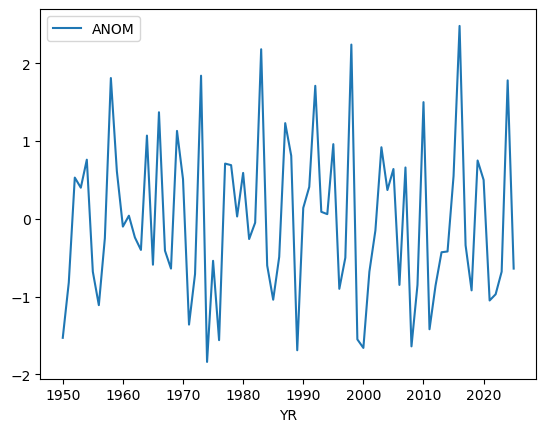

In [8]:
# quick viz
# djf only
dataset[dataset["SEAS"]=="DJF"].plot("YR","ANOM")

In [8]:
# train test split by years
trainds = dataset[dataset["YR"]<=2010]
testsds = dataset[dataset["YR"]>2010]

In [9]:
# grab anoms columns (ONI) and reset index
# reshape to be (samples, features)
# number of features here is just 1 (ONI)
trainds = trainds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)
testsds = testsds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)

In [10]:
# checking shapes -- make sure (samples, features)
print(trainds.shape, testsds.shape)

(732, 1) (157, 1)


In [11]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

In [12]:
# do rescaling
trainds_scaled = sc.fit_transform(trainds)
testsds_scaled = sc.transform(testsds)

# Many-to-One LSTM

In [13]:
# for help with data manipulation for time series rnn training; we can use the time series generator from keras

# dummy input for understanding
# data = np.array([[i] for i in range(50)])

# here goes our training data
data = trainds_scaled

# the shape of your target is your prediction shape (e.g., here we make it 1)
target = data

# the length of the input feature
n_input=4 # you can change this! doesn't HAVE to be 4 months input
n_features=data.shape[1]

# this is the generator that will go into our rnn for training
data_gen = TimeseriesGenerator(data,
                               target,
                               length=n_input,
                               sampling_rate=1,
                               batch_size=16, # you can try different batch sizes
                               shuffle=True)

In [14]:
# check shapes
print(data.shape, target.shape, n_features)

(732, 1) (732, 1) 1


In [15]:
# quick check of output
batch_0 = data_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

[[0.53724605]
 [0.51241535]
 [0.51241535]
 [0.48532731]] [0.4469526]
(16, 4, 1) (16, 1)


In [16]:
# many-to-one example
# lets make our rnn!
regressor = Sequential()

# LSTM; input shape is 1 (for one time step at a time) and n_features which is also 1 for our toy example
regressor.add(keras.layers.Input(shape=(1, n_features), batch_size=16))

# don't return sequence; just the last output of the input sequence
regressor.add(LSTM(units=50, return_sequences=False))

# one neuron for output prediction
regressor.add(Dense(1))
regressor.add(Activation('linear'))

# compile model
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# what does graph look like?
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (16, 50)                  10400     
                                                                 
 dense (Dense)               (16, 1)                   51        
                                                                 
 activation (Activation)     (16, 1)                   0         
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# train the lstm!
regressor.fit(data_gen, epochs=20)

Epoch 1/20
46/46 [==============================] - 2s 5ms/step - loss: 0.0557 - mse: 0.0557 - mae: 0.1771
Epoch 2/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0114 - mse: 0.0114 - mae: 0.0836
Epoch 3/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0107 - mse: 0.0107 - mae: 0.0807
Epoch 4/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0787
Epoch 5/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0093 - mse: 0.0093 - mae: 0.0743
Epoch 6/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0710
Epoch 7/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0718
Epoch 8/20
46/46 [==============================] - 0s 4ms/step - loss: 0.0089 - mse: 0.0089 - mae: 0.0759
Epoch 9/20
46/46 [==============================] - 0s 5ms/step - loss: 0.0075 - mse: 0.0075 - mae: 0.0663
Epoch 10/20
46/46 [==================

In [18]:
# here goes our testing data that was already scaled
testdata = testsds_scaled

testtarget = testdata

testdata_gen = TimeseriesGenerator(
    testdata,
    testtarget,
    length=n_input,
    sampling_rate=1,
    batch_size=testdata.shape[0], # all samples
    shuffle=False)

In [19]:
# quick check of output
batch_0 = testdata_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

[[0.13769752]
 [0.18961625]
 [0.248307  ]
 [0.29345372]] [0.33408578]
(153, 4, 1) (153, 1)


In [20]:
# predict using test data
oni_predictions = regressor.predict(testdata_gen)

1/1 [==============================] - 1s 1s/step


In [21]:
# quick check that we have a match of shapes
print(oni_predictions.shape, y.shape)

(153, 1) (153, 1)


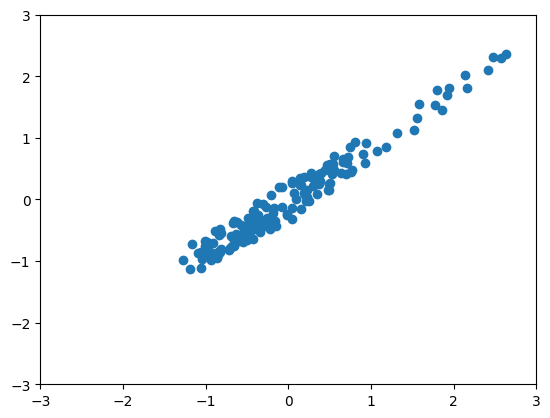

In [22]:
# how did we do!?
plt.scatter(
    sc.inverse_transform(y).reshape(-1),
    sc.inverse_transform(oni_predictions).reshape(-1)
    )
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

# Many-to-Many LSTM

In [23]:
# redoing data preprocessing steps here more quickly

# reading dataset from NOAA online
dataset = pd.read_csv(
    'http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt',
    delim_whitespace=True)

# drop any nans
dataset = dataset.dropna(subset=["ANOM"])

# train test split by years
trainds = dataset[dataset["YR"]<=2010]
testsds = dataset[dataset["YR"]>2010]

# grab anoms columns (ONI) and reset index
# reshape to be (samples, features)
# number of features here is just 1 (ONI)
trainds = trainds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)
testsds = testsds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)

# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

# do rescaling
trainds_scaled = sc.fit_transform(trainds)
testsds_scaled = sc.transform(testsds)

In [24]:
# for help with data manipulation for time series rnn training; we can use the time series generator from keras

# dummy input for understanding
# data = np.array([[i] for i in range(50)])

# here goes our training data
data = trainds_scaled

# the shape of your target is your prediction shape
target = np.concatenate((np.roll(data, 0, axis=0),
                         np.roll(data, -1, axis=0),
                         np.roll(data, -2, axis=0),
                         #np.roll(data, -3, axis=0)
                        ), axis=1)

# the length of the input feature
n_input=4
n_features=data.shape[1]
n_pred=target.shape[1]

# this is the generator that will go into our rnn for training
data_gen = TimeseriesGenerator(data,
                               target,
                               length=n_input,
                               sampling_rate=1,
                               batch_size=16,
                               shuffle=True)

In [25]:
# quick check of output
batch_0 = data_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape, n_features)

[[0.37923251]
 [0.4717833 ]
 [0.55079007]
 [0.60948081]] [0.66591422 0.71331828 0.76749436]
(16, 4, 1) (16, 3) 1


In [26]:
# many-to-one example

# lets make our rnn!
regressor = Sequential()

# LSTM; input shape is 1 (for one time step at a time) and n_features which is also 1 for our toy example
regressor.add(keras.layers.Input(shape=(1, n_features), batch_size=16))

# encoder is needed because we are using many to predict future manys
# return sequence
regressor.add(LSTM(units=50, return_sequences=False))

# one neuron for output prediction needs to be repeated for each future many prediction
regressor.add(RepeatVector(n_pred))

# decoder to predict; return each prediction so return_sequence=True
# return sequence
regressor.add(LSTM(units=50, return_sequences=True))

# predict 1 value per returned sequence value
regressor.add(TimeDistributed(Dense(1)))
regressor.add(Activation('linear'))

# compile model
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

# what does graph look like?
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (16, 50)                  10400     
                                                                 
 repeat_vector (RepeatVecto  (16, 3, 50)               0         
 r)                                                              
                                                                 
 lstm_2 (LSTM)               (16, 3, 50)               20200     
                                                                 
 time_distributed (TimeDist  (16, 3, 1)                51        
 ributed)                                                        
                                                                 
 activation_1 (Activation)   (16, 3, 1)                0         
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 3065

In [27]:
# train the lstm!
regressor.fit(data_gen, epochs=20)

Epoch 1/20
46/46 [==============================] - 6s 13ms/step - loss: 0.0764 - mse: 0.0764 - mae: 0.2227
Epoch 2/20
46/46 [==============================] - 1s 14ms/step - loss: 0.0258 - mse: 0.0258 - mae: 0.1262
Epoch 3/20
46/46 [==============================] - 1s 15ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0965
Epoch 4/20
46/46 [==============================] - 1s 13ms/step - loss: 0.0146 - mse: 0.0146 - mae: 0.0930
Epoch 5/20
46/46 [==============================] - 1s 14ms/step - loss: 0.0157 - mse: 0.0157 - mae: 0.0954
Epoch 6/20
46/46 [==============================] - 1s 15ms/step - loss: 0.0142 - mse: 0.0142 - mae: 0.0920
Epoch 7/20
46/46 [==============================] - 1s 16ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0860
Epoch 8/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0109 - mse: 0.0109 - mae: 0.0814
Epoch 9/20
46/46 [==============================] - 1s 12ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0787
Epoch 10/20
46/46 [=========

In [28]:
# here goes our testing data
testdata = testsds_scaled

# make sure you make this match your training target
testtarget = np.concatenate((
    np.roll(testdata, 0, axis=0),
    np.roll(testdata, -1, axis=0),
    np.roll(testdata, -2, axis=0),
    #np.roll(testdata, -3, axis=0)
    ), axis=1)

testdata_gen = TimeseriesGenerator(
    testdata,
    testtarget,
    length=n_input,
    sampling_rate=1,
    batch_size=testdata.shape[0], # all samples
    shuffle=False)

In [29]:
# quick check of output
batch_0 = testdata_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

[[0.13769752]
 [0.18961625]
 [0.248307  ]
 [0.29345372]] [0.33408578 0.35891648 0.34988713]
(153, 4, 1) (153, 3)


In [30]:
# make predictions
oni_predictions = regressor.predict(testdata_gen)

1/1 [==============================] - 2s 2s/step


In [31]:
# check shapes match
print(oni_predictions.shape, y.shape)

(153, 3, 1) (153, 3)


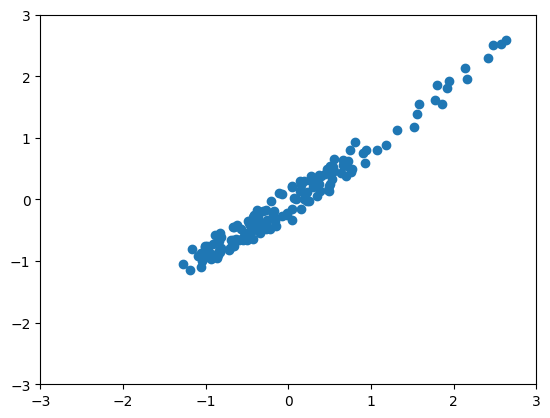

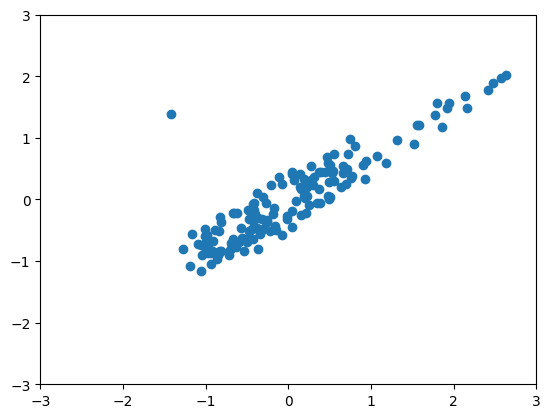

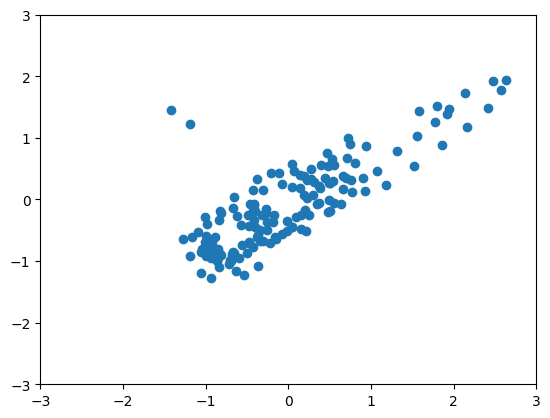

In [32]:
for i in range(0, n_pred):
    # how did we do!?
    plt.scatter(
        sc.inverse_transform(y[:, i].reshape(-1, 1)).reshape(-1),
        sc.inverse_transform(oni_predictions[:, i].reshape(-1, 1)).reshape(-1)
        )
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.show()